---
title: London Amenities
date-format: long
date-modified: last-modified
lang: en
language:
  title-block-modified: "Last update"
---


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

## Data and preparation

This examples calculates landuse accessibility to pubs and restaurants for London

For additional information on network preparation, see the corresponding notebook on [graph cleaning](https://colab.research.google.com/github/cityseer/cityseer/blob/master/demos/graph_cleaning.ipynb).

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

The landuse amenity data is taken from `OpenStreetMap` via `osmnx`.


In [13]:
from cityseer.tools import graphs, io

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
plot_buffer = 2000
# creates a WGS shapely polygon
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer)
poly_utm, _ = io.buffered_point_poly(lng, lat, buffer, projected=True)
plot_bbox = poly_utm.centroid.buffer(plot_buffer).bounds

Prepare the amenities GeoDataFrame.


In [3]:
# prepare data layer
from cityseer.metrics import layers
from osmnx import features

data_gdf = features.features_from_place(
    "London", tags={"amenity": ["pub", "restaurant"]}
)

# convert to the same UTM CRS as the network
data_gdf = data_gdf.to_crs(
    32630
)  # to match EPSG code for UTM zone 30N per network data

# extract nodes
data_gdf = data_gdf.loc["node"]
data_gdf = data_gdf.reset_index(level=0, drop=True)
# set index to string for cityseer compatibility
data_gdf.index = data_gdf.index.astype(str)
# extract relevant columns
data_gdf = data_gdf[["amenity", "geometry"]]
print(data_gdf.head())

      amenity                        geometry
0         pub  POINT (694282.233 5720372.951)
1  restaurant  POINT (694353.653 5720508.222)
2         pub  POINT (694189.282 5720228.905)
3         pub  POINT (695475.171 5721895.793)
4         pub  POINT (709733.415 5720007.168)


Fetch and simplify the street network. The street network will be decomposed for a higher resolution analysis.


In [4]:
# generate OSM graph from polygon
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_utm, 25)
# prepare the data structures
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(
    G_decomp, crs=32629
)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 181022/181022 [00:00<00:00, 955658.72it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 198319/198319 [00:00<00:00, 1760679.57it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 198319/198319 [00:01<00:00, 130575.41it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 181022/181022 [00:07<00:00, 25398.68it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 82251/82251 [00:05<00:00, 14540.92it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 61088/61088 [00:00<00:00, 132556.78it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 57547/57547 [00:00<00:00, 444312.42it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
10

In [5]:
# compute pub accessibility
distances = [100, 200, 400, 800]
nodes_gdf, pubs_data_gdf = layers.compute_accessibilities(
    data_gdf,
    landuse_column_label="amenity",
    accessibility_keys=["pub", "restaurant"],
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    distances=distances,
)

INFO:cityseer.metrics.layers:Computing land-use accessibility for: pub, restaurant
100%|██████████| 79184/79184 [00:26<00:00, 2995.47it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 100m, Beta: 0.04, Walking Time: 1.25 minutes.
INFO:cityseer.config:Distance: 200m, Beta: 0.02, Walking Time: 2.5 minutes.
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.
INFO:cityseer.config:Distance: 800m, Beta: 0.005, Walking Time: 10.0 minutes.


The output GeoDataFrame will contain new columns for each landuse and distance combination. For each of these the following will have been computed:

- A count of reachable instances of a given landuse (within the specified distance thresholds)
- Similarly, a distance-weighted count of reachable locations
- The distance to the nearest instance of a given landuse. Where there are no reachable landuses for a given node within the specified distance threshold, then a `np.inf` value will be returned.


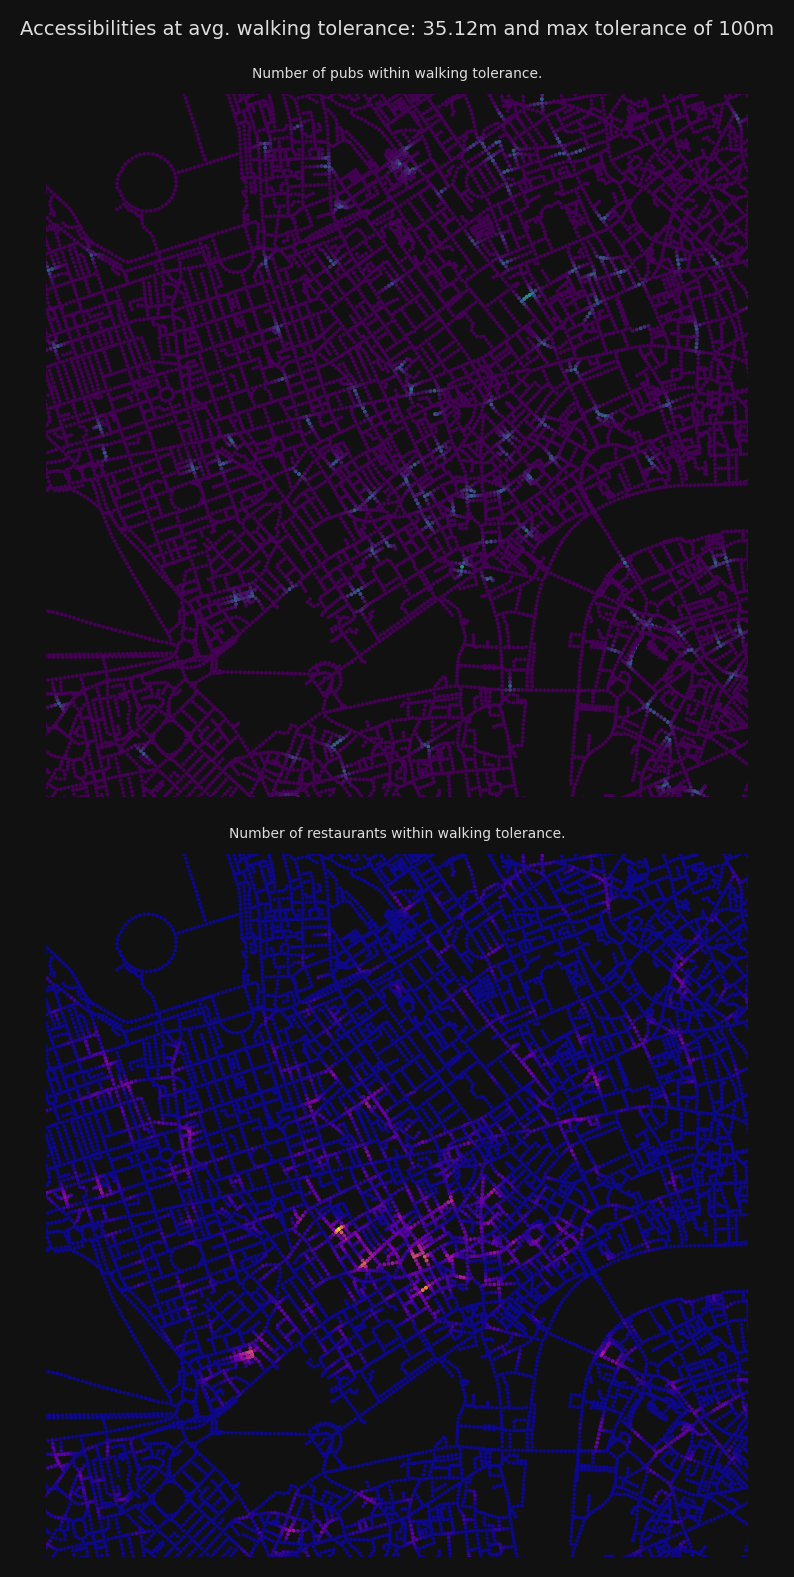

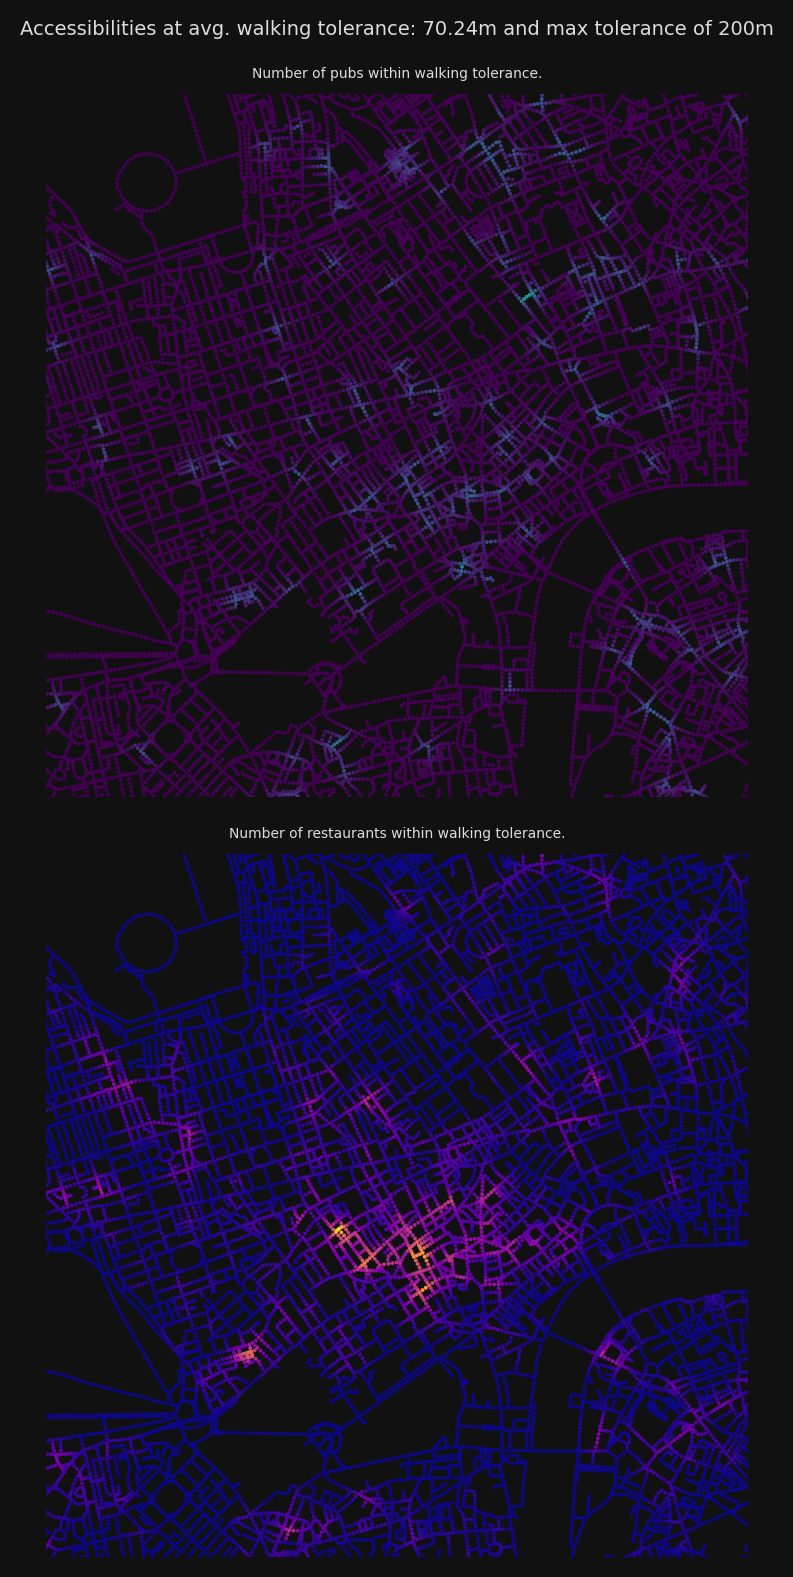

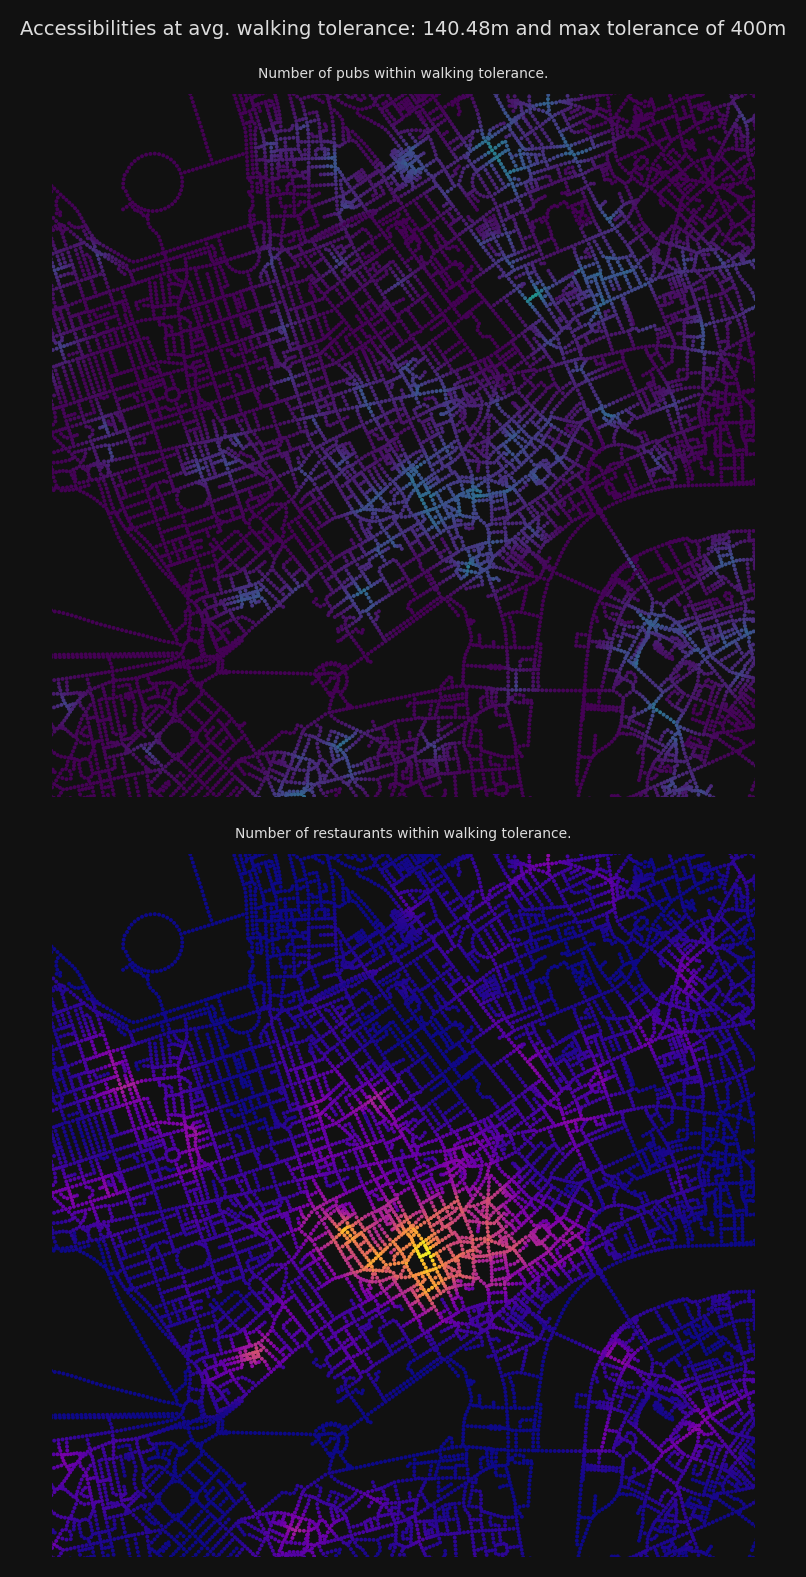

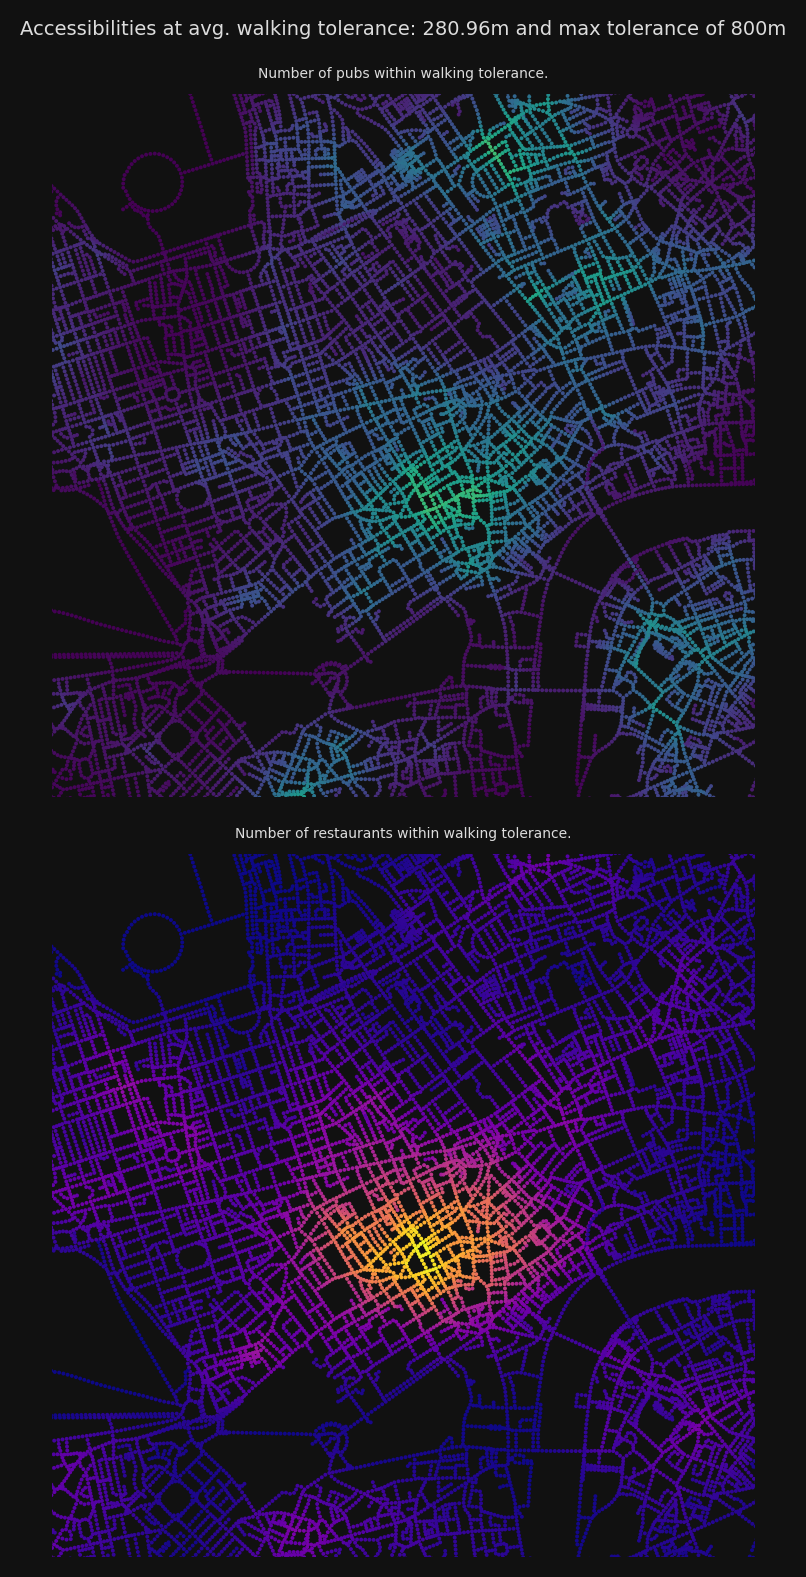

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from cityseer import rustalgos
from cityseer.tools import plot

bg_colour = "#111"
text_colour = "#ddd"
font_size = 5
betas = rustalgos.betas_from_distances(distances)
avg_dists = rustalgos.avg_distances_for_betas(betas)

for d, b, avg_d in zip(distances, betas, avg_dists):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=200, facecolor=bg_colour)
    fig.suptitle(
        f"Accessibilities at avg. walking tolerance: {avg_d:.2f}m and max tolerance of {d}m",
        color=text_colour,
        fontsize=7,
    )
    nodes_gdf.plot(
        column=f"cc_pub_{d}_wt",
        cmap="viridis",
        legend=False,
        ax=axes[0],
        markersize=2,
        edgecolor="none",
    )
    axes[0].set_title(
        "Number of pubs within walking tolerance.",
        color=text_colour,
        fontsize=font_size,
    )
    # set the axis limits
    axes[0].set_xlim(plot_bbox[0], plot_bbox[2])
    axes[0].set_ylim(plot_bbox[1], plot_bbox[3])
    # turn off the axis
    axes[0].axis(False)

    nodes_gdf.plot(
        column=f"cc_restaurant_{d}_wt",
        cmap="plasma",
        legend=False,
        ax=axes[1],
        markersize=2,
        edgecolor="none",
    )
    axes[1].set_title(
        "Number of restaurants within walking tolerance.",
        color=text_colour,
        fontsize=font_size,
    )

    # set the axis limits
    axes[1].set_xlim(plot_bbox[0], plot_bbox[2])
    axes[1].set_ylim(plot_bbox[1], plot_bbox[3])
    # turn off the axis
    axes[1].axis(False)

    fig.tight_layout()
    plt.show()

/var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/ipykernel_57639/2561977630.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_data[np.isinf(dist_data)] = max(distances)
/var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/ipykernel_57639/2561977630.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_data[np.isinf(dist_data)] = max(distances)


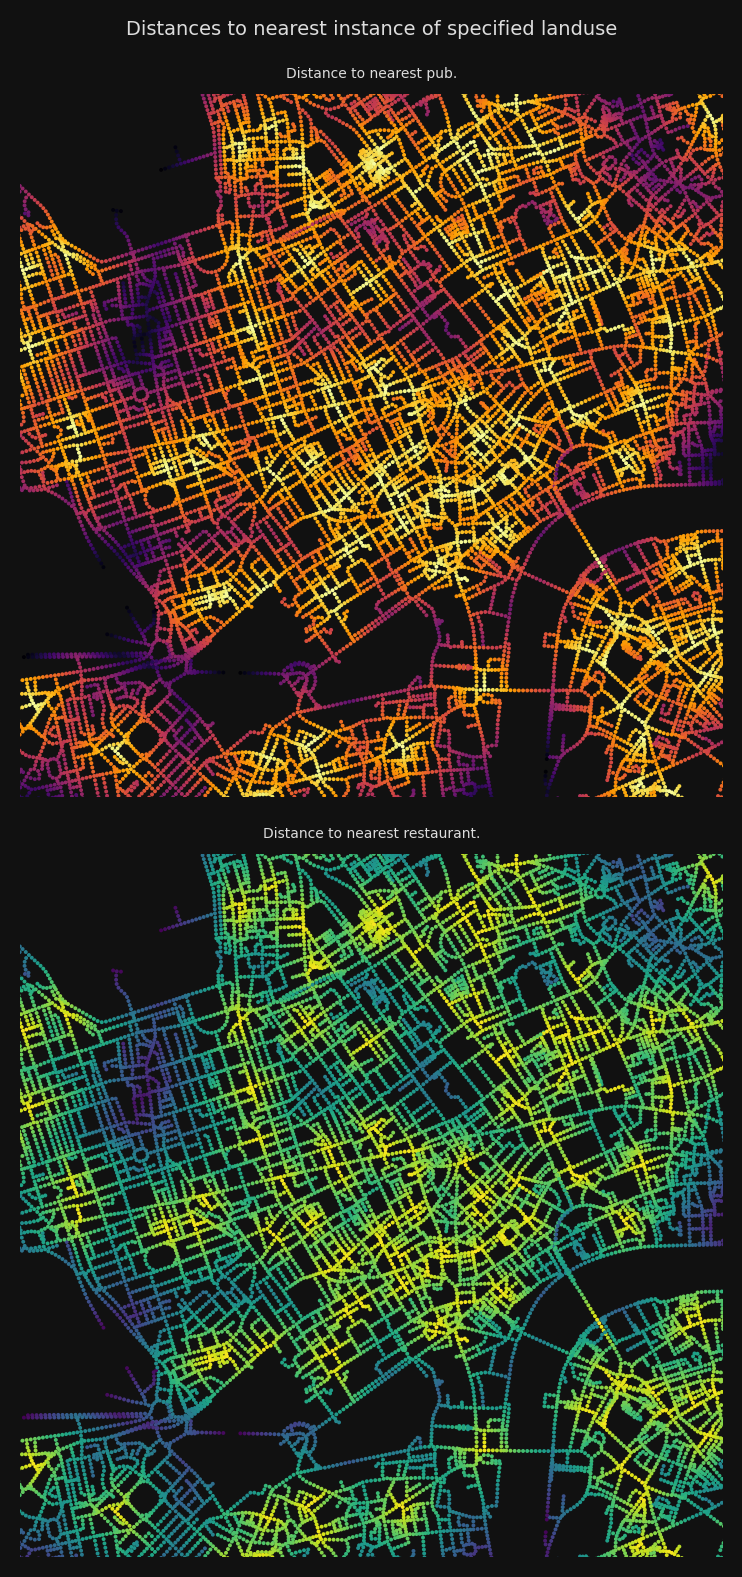

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), dpi=200, facecolor=bg_colour)
fig.suptitle(
    f"Distances to nearest instance of specified landuse",
    color=text_colour,
    fontsize=7,
)

dist_data = nodes_gdf[f"cc_pub_nearest_max_{max(distances)}"]
dist_data[np.isinf(dist_data)] = max(distances)

nodes_gdf.plot(
    column=f"cc_pub_nearest_max_{max(distances)}",
    cmap="inferno_r",
    legend=False,
    ax=axes[0],
    markersize=2,
    edgecolor="none",
)

axes[0].set_title("Distance to nearest pub.", color=text_colour, fontsize=font_size)
# set the axis limits
axes[0].set_xlim(plot_bbox[0], plot_bbox[2])
axes[0].set_ylim(plot_bbox[1], plot_bbox[3])
# turn off the axis
axes[0].axis(False)

dist_data = nodes_gdf[f"cc_restaurant_nearest_max_{max(distances)}"]
dist_data[np.isinf(dist_data)] = max(distances)

nodes_gdf.plot(
    column=f"cc_pub_nearest_max_{max(distances)}",
    cmap="viridis_r",
    legend=False,
    ax=axes[1],
    markersize=2,
    edgecolor="none",
)
axes[1].set_title(
    "Distance to nearest restaurant.", color=text_colour, fontsize=font_size
)
# set the axis limits
axes[1].set_xlim(plot_bbox[0], plot_bbox[2])
axes[1].set_ylim(plot_bbox[1], plot_bbox[3])
# turn off the axis
axes[1].axis(False)

fig.tight_layout()
plt.show()